# Lego defect detection
### This notebook trains and evaluates a ResNet18 pretrained classifier on Lego brick images organized into:
    - 'defect' and 'no_defect' folders for both train and valid splits.
For computational constrains, images will be resized to (224, 224) and no augmentation techniques will be applied.

In [17]:
# import libraries
import numpy as np
import os
import shutil
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, confusion_matrix, classification_report

In [3]:
# 1. Define parameters
data_dir = './'
train_dir = os.path.join(data_dir, 'train') 
valid_dir = os.path.join(data_dir, 'valid')
num_classes = 2  # 'defect' and 'no_defect'
batch_size = 16
num_epochs = 10
learning_rate = 0.001

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set a fixed random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# 2. Data transforms
# Images are resized to 224x224 and converted to tensors
transform = transforms.Compose([
    transforms.transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 3. Define datasets and loaders
# ImageFolder expects data in class subfolders (defect/no_defect)
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes: {train_dataset.classes}")
print(train_dataset.class_to_idx)

Classes: ['defect', 'no_defect']
{'defect': 0, 'no_defect': 1}


In [8]:
# 4. Load pretrained ResNet and freeze backbone
# We use a ResNet18 pretrained on ImageNet

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Freeze all layers so only the final layer is trained
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match our number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [10]:
# 5. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

In [12]:
# 6. Training loop
print("Starting training...")
train_losses = []
valid_losses = []

num_epochs = 8

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # --- Validation loss ---
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
    val_epoch_loss = val_running_loss / len(valid_loader.dataset)
    valid_losses.append(val_epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, loss: {epoch_loss:.4f}, Val_loss: {val_epoch_loss:.4f}")



Starting training...
Epoch 1/8, loss: 0.5420, Val_loss: 0.5284
Epoch 2/8, loss: 0.4544, Val_loss: 0.5060
Epoch 3/8, loss: 0.4254, Val_loss: 0.4809
Epoch 4/8, loss: 0.3907, Val_loss: 0.4676
Epoch 5/8, loss: 0.3982, Val_loss: 0.4465
Epoch 6/8, loss: 0.3774, Val_loss: 0.4139
Epoch 7/8, loss: 0.3444, Val_loss: 0.4061
Epoch 8/8, loss: 0.3211, Val_loss: 0.3964


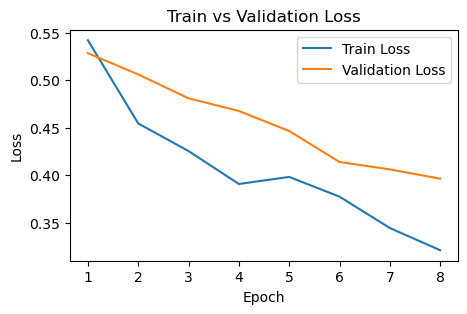

In [13]:
# Plot the loss curves
plt.figure(figsize=(5,3))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [14]:
# 7. Evaluation
# We evaluate the model using precision (for the 'defect' class)
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Compute precision for the 'defect' class (in our case is class 0)
precision = precision_score(all_labels, all_preds, pos_label=0, zero_division=0)
print(f"Validation Precision (defect class): {precision:.4f}")

# Compute and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)


Validation Precision (defect class): 0.8490
Confusion Matrix:
[[208   8]
 [ 37  47]]


In [15]:
class_report = classification_report(all_labels, all_preds)
print(class_report)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       216
           1       0.85      0.56      0.68        84

    accuracy                           0.85       300
   macro avg       0.85      0.76      0.79       300
weighted avg       0.85      0.85      0.84       300



# The more data, the better performance

In [32]:
# Create new full_train folders
os.makedirs('full_train/defect', exist_ok=True)
os.makedirs('full_train/no_defect', exist_ok=True)

# Copy train images
for cls in ['defect', 'no_defect']:
    for fname in os.listdir(f'train/{cls}'):
        shutil.copy2(f'train/{cls}/{fname}', f'full_train/{cls}/{fname}')
# Copy valid images
for cls in ['defect', 'no_defect']:
    for fname in os.listdir(f'valid/{cls}'):
        shutil.copy2(f'valid/{cls}/{fname}', f'full_train/{cls}/{fname}')

# Create dataset and loader for full_train
full_train_dataset = datasets.ImageFolder('full_train', transform=transform)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)

# Re-initialize the model (optional, for a fresh start)
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Use the same loss and optimizer (add class weights if you want)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Train on full_train (no validation)
print("Starting final training on all data...")
final_train_losses = []
num_epochs_full = 10  # You can set this to any number

for epoch in range(num_epochs_full):
    model.train()
    running_loss = 0.0
    for images, labels in full_train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(full_train_loader.dataset)
    final_train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs_full}, loss: {epoch_loss:.4f}")

# Save the final model
torch.save(model.state_dict(), 'lego_resnet18_full.pth')
print("Full-data-trained model weights saved as lego_resnet18_full.pth")


In [ ]:
# save the models weights
torch.save(model.state_dict(), 'lego_resnet18_full.pth')

In [38]:
# Recreate the model architecture
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


<All keys matched successfully>

In [ ]:
# --- Test set evaluation ---
test_dir = os.path.join(data_dir, 'test')
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the saved weights
model.load_state_dict(torch.load('lego_resnet18_full.pth', map_location=device))

# Now we can run predictions on your test set
model.eval()
test_labels = []
test_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())

test_precision = precision_score(test_labels, test_preds, pos_label=0, zero_division=0)
print(f"Test Precision (defect class): {test_precision:.4f}")
test_cm = confusion_matrix(test_labels, test_preds)
print('Test Confusion Matrix:')
print(test_cm)
print(f"      Predicted: no_defect   defect")
print(f"Actual: no_defect    {test_cm[0,0]:5d}        {test_cm[0,1]:5d}")
print(f"        defect        {test_cm[1,0]:5d}        {test_cm[1,1]:5d}")

class_report = classification_report(test_labels, test_preds, target_names=['defect', 'no_defect'])
print(class_report)